<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
For reference, I followed <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# Stage 1: Building the LLM


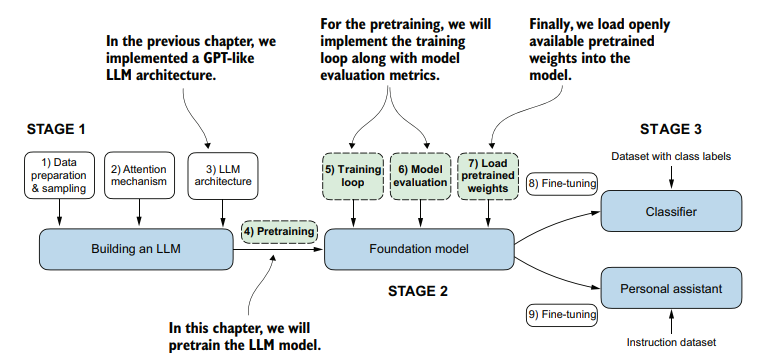

## Import libraries


In [ ]:
import torch
import torch.nn as nn
import tiktoken

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

<div class="alert alert-block alert-info">
    
Step 1: Tokenize the entire text
    
Step 2: Use a sliding window to chunk the book into overlapping sequences of max_length

Step 3: Return the total number of rows in the dataset

Step 4: Return a single row from the dataset
</div>

## Dataset & DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class GPT_dataset(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        #Tokenize the text
        token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

        #Seperating input, output pairs
        for i in range (0, len(token_ids) - max_length, stride):
            input_pair = token_ids[i:i+max_length]
            target_pair = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_pair))
            self.target_ids.append(torch.tensor(target_pair))

    def __len__(self):
        return len(self.input_ids)

    #Dataloader needs getitem to fetch input output pairs
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

<div class="alert alert-block alert-info">
    
Step 1: Initialize the tokenizer

Step 2: Create dataset

Step 3: drop_last = True

Step 4: num_workers (The number of CPU processes for parallel preprocessing)
    
</div>

In [ ]:
def create_dataloader(text, batch_size = 4, max_length = 256, stride = 128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPT_dataset(text, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last, #drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training
        num_workers=num_workers
    )
    return dataloader

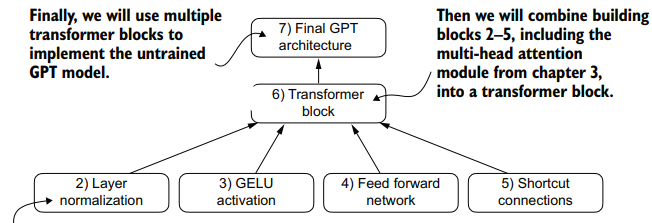

### Layer Normalization

In [ ]:
class Layer_Norm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) #keepdim = True ensures that the output tensor retains the same number of dimensions as the input tensor, even though the operation reduces the tensor along the dimension specified via dim.
        var = x.var(dim=-1, keepdim=True, unbiased=False) #type of variance calculation, we divide by the number of inputs n in the variance formula.
        normalized_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * normalized_x + self.shift

### GeLU activation

In [ ]:
class Gelu(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3)))) #GeLU activation formula

### Feed Forward network

In [ ]:
class Feed_forward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4 * config["emb_dim"]), ## Expansion
            Gelu(),  ## Activation
            nn.Linear(4 * config["emb_dim"], config["emb_dim"]) ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

## Transformer block

In [ ]:
class Transformer_Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = MultiheadAttention(
            d_in = config["emb_dim"],
            d_out = config["emb_dim"],
            context_length = config["context_length"],
            num_heads = config["n_heads"],
            qkv_bias = config["qkv_bias"],
            dropout = config["drop_rate"],
        )
        self.ff = Feed_forward(config)
        self.layer_norm_1 = Layer_Norm(config["emb_dim"])
        self.layer_norm_2 = Layer_Norm(config["emb_dim"])
        self.dropout = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        #shortcut for attention block
        short_connect = x
        x = self.layer_norm_1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + short_connect

        #shortcut for feed forward block
        short_connect = x
        x = self.layer_norm_2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + short_connect

        return x

## Attention Mechanism

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias) # Shape: 6 x 6
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape  # 1 x 3 x 6 tensor

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

## Final GPT model
### Initialized random weights without pretraining

In [ ]:
class MyGPTmodel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
        self.drop = nn.Dropout(config["drop_rate"])

        self.trf_stack = nn.Sequential(
            *[Transformer_Block(config) for _ in range(config["n_layers"])]
        )

        self.final_layer_norm = Layer_Norm(config["emb_dim"])
        self.output_head = nn.Linear(
            config["emb_dim"], config["vocab_size"], bias = False
        )

    # Takes the input and generates output
    def forward(self, input_idx):
        batch_size, seq_len = input_idx.shape            # batch size = no of batches, sequence length = no of input tokens
        tok_embeds = self.token_emb(input_idx)           # Every token there'll be 768 dim embeddings, max can be (50257 x 768), but we need only four (4 x 768)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=input_idx.device))  #Depends on context size (1024 x 768) but we need only four positions
        x = tok_embeds + pos_embeds   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop(x)
        x = self.trf_stack(x)
        x = self.final_layer_norm(x)
        logits = self.output_head(x)
        return logits

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [ ]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


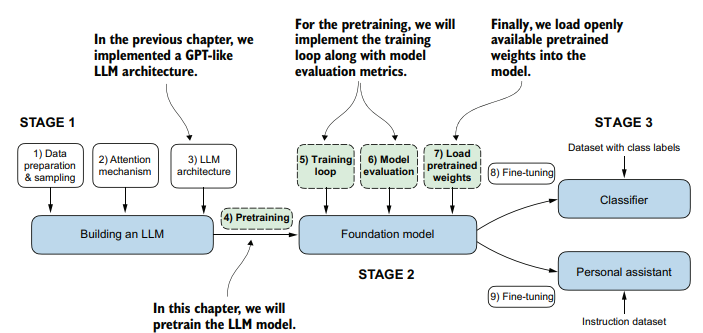

# Stage 2: Foundational Model


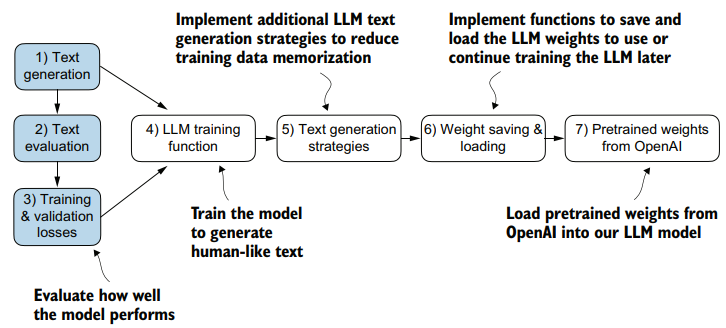

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

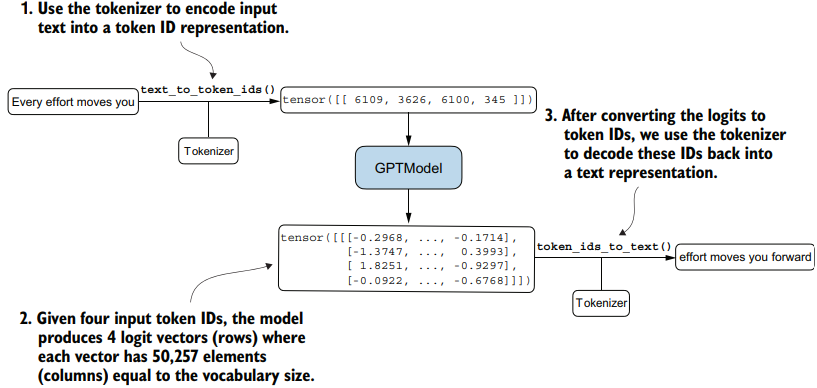

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    decoded = tokenizer.decode(flat.tolist())
    return decoded

In [ ]:
# start_context = "Every effort moves you"

# token_ids = generate_text_simple(
#     model=model,
#     idx=text_to_token_ids(start_context, tokenizer),
#     max_new_tokens=10,
#     context_size=GPT_CONFIG_124M["context_length"]
# )

# print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

In [ ]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

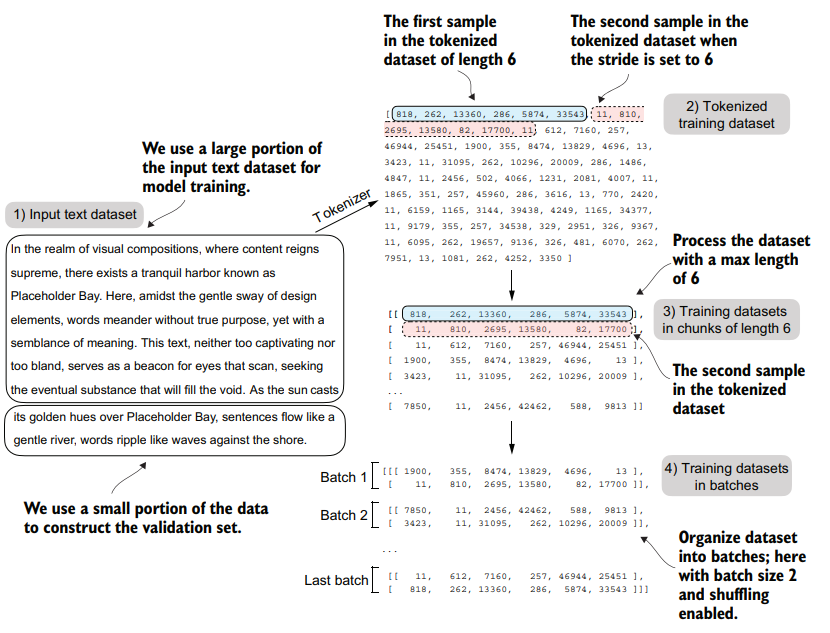

In [ ]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [ ]:
torch.manual_seed(123)

train_loader = create_dataloader(
    train_data,
    batch_size=2, #for faster operation
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"], #prevent overlapping
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
# Sanity check

# if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
#     print("Not enough tokens for the training loader. "
#           "Try to lower the `GPT_CONFIG_124M['context_length']` or "
#           "increase the `training_ratio`")

# if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
#     print("Not enough tokens for the validation loader. "
#           "Try to lower the `GPT_CONFIG_124M['context_length']` or "
#           "decrease the `training_ratio`")

In [ ]:
print("Train loader:")
for x, y in train_loader:
 print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
 print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [ ]:
#optional check that data loaded correctly or not
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [ ]:
torch.manual_seed(123)
model = MyGPTmodel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

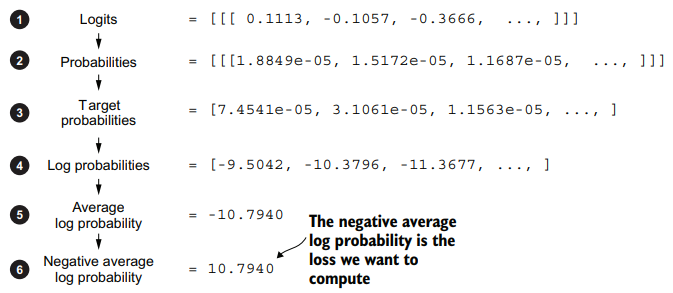

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) # Iteratives over all batches if no fixed num_batches is specified
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches  # Averages the loss over all batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


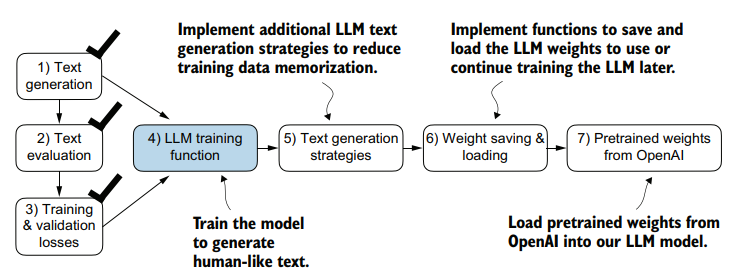

## LLM training function

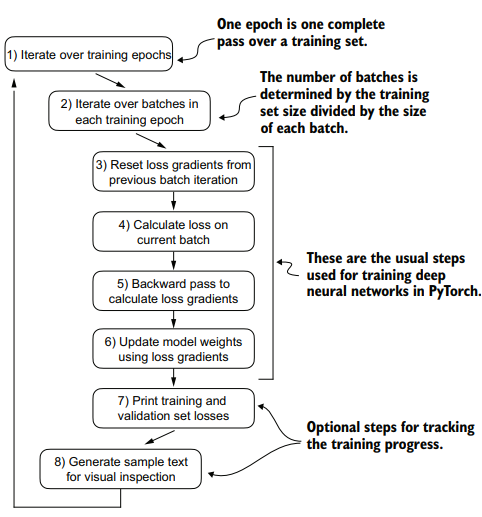

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
import time
start_time = time.time()

torch.manual_seed(123)
model = MyGPTmodel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=text_data, tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)  "The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon

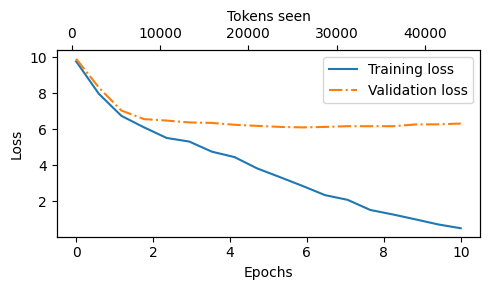

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

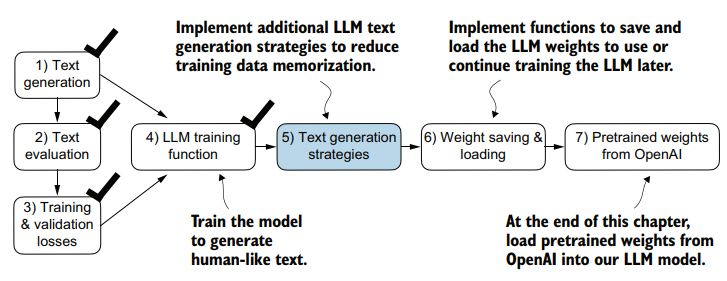

## Text generation strategies

In [ ]:
model.eval()

MyGPTmodel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_stack): Sequential(
    (0): Transformer_Block(
      (attn): MultiheadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): Feed_forward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): Gelu()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm_1): Layer_Norm()
      (layer_norm_2): Layer_Norm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Transformer_Block(
      (attn): MultiheadAttention(
        (W_query): Line

In [ ]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_data, tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well!--e

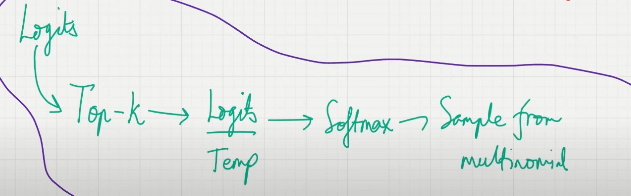

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

<div>

As we can see, Model is giving nonsensical outputs but it is still in learning phase. If we hypertune the parameters more or less, we will get better outputs.
</div>

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(text_data, tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well!--e

## Model weight saving

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

## Load pretrained weights from GPT2 small(124M)

In [ ]:
pip install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

TensorFlow version: 2.18.0
tqdm version: 4.67.1


In [ ]:
from gpt_download3 import download_and_load_gpt2

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 164kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 622kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificati

In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [ ]:
GPT_CONFIG_124M_Org = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 1024, # Updated original
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": True      # Updated original Query-key-value bias
}

In [ ]:
gpt = MyGPTmodel(GPT_CONFIG_124M_Org)
gpt.eval()

MyGPTmodel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_stack): Sequential(
    (0): Transformer_Block(
      (attn): MultiheadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): Feed_forward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): Gelu()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm_1): Layer_Norm()
      (layer_norm_2): Layer_Norm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Transformer_Block(
      (attn): MultiheadAttention(
        (W_query): Linear

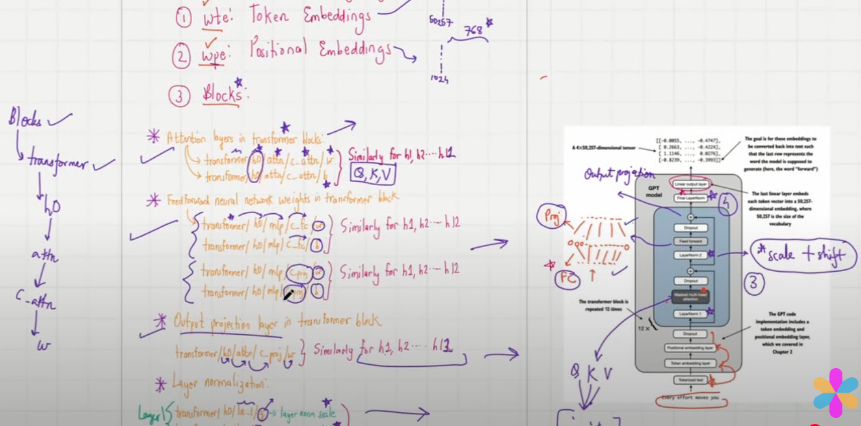

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

## Merging pretrained weights with my gpt model

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_stack[b].attn.W_query.weight = assign(
            gpt.trf_stack[b].attn.W_query.weight, q_w.T)
        gpt.trf_stack[b].attn.W_key.weight = assign(
            gpt.trf_stack[b].attn.W_key.weight, k_w.T)
        gpt.trf_stack[b].attn.W_value.weight = assign(
            gpt.trf_stack[b].attn.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_stack[b].attn.W_query.bias = assign(
            gpt.trf_stack[b].attn.W_query.bias, q_b)
        gpt.trf_stack[b].attn.W_key.bias = assign(
            gpt.trf_stack[b].attn.W_key.bias, k_b)
        gpt.trf_stack[b].attn.W_value.bias = assign(
            gpt.trf_stack[b].attn.W_value.bias, v_b)

        gpt.trf_stack[b].attn.out_proj.weight = assign(
            gpt.trf_stack[b].attn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_stack[b].attn.out_proj.bias = assign(
            gpt.trf_stack[b].attn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_stack[b].ff.layers[0].weight = assign(
            gpt.trf_stack[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_stack[b].ff.layers[0].bias = assign(
            gpt.trf_stack[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_stack[b].ff.layers[2].weight = assign(
            gpt.trf_stack[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_stack[b].ff.layers[2].bias = assign(
            gpt.trf_stack[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_stack[b].layer_norm_1.scale = assign(
            gpt.trf_stack[b].layer_norm_1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_stack[b].layer_norm_1.shift = assign(
            gpt.trf_stack[b].layer_norm_1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_stack[b].layer_norm_2.scale = assign(
            gpt.trf_stack[b].layer_norm_2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_stack[b].layer_norm_2.shift = assign(
            gpt.trf_stack[b].layer_norm_2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_layer_norm.scale = assign(gpt.final_layer_norm.scale, params["g"])
    gpt.final_layer_norm.shift = assign(gpt.final_layer_norm.shift, params["b"])
    gpt.output_head.weight = assign(gpt.output_head.weight, params["wte"])

In [ ]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

<div>
    
As we can see, after using pretrained weights given by OpenAI for gpt2 small(124M), model is giving better and intelligent response.



> "With that one look he moved again, and with that smile he said at the end—"Now I know where the"


</div>

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(text_data, tokenizer).to(device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M_Org["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well!--e